In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np
import argparse
import os
import time
import IPython
import pyworld as pw

from styler import STYLER
from dataset import Dataset
from evaluate import evaluate
from synthesize import preprocess_text, synthesize, read, preprocess_audio, get_processed_data_from_wav
import hparams as hp
import utils
import audio as Audio
import pandas as pd
import sqlite3
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
torch.manual_seed(0)

# Get device
device = torch.device('cuda'if torch.cuda.is_available()else 'cpu')


# Define model
model = nn.DataParallel(STYLER()).to(device)

checkpoint_path = os.path.join(hp.checkpoint_path())
checkpoint = torch.load(os.path.join(
    checkpoint_path, 'checkpoint_1190000.pth.tar'))
model.load_state_dict(checkpoint['model'])

# Load vocoder
vocoder = utils.get_vocoder()

model.requires_grad = False
model.eval()

Removing weight norm...


DataParallel(
  (module): STYLER(
    (style_modeling): StyleModeling(
      (style_encoder): StyleEncoder(
        (text_encoder): Encoder(
          (src_word_emb): Embedding(152, 256, padding_idx=0)
          (layer_stack): ModuleList(
            (0): FFTBlock(
              (slf_attn): MultiHeadAttention(
                (w_qs): Linear(in_features=256, out_features=256, bias=True)
                (w_ks): Linear(in_features=256, out_features=256, bias=True)
                (w_vs): Linear(in_features=256, out_features=256, bias=True)
                (attention): ScaledDotProductAttention(
                  (softmax): Softmax(dim=2)
                )
                (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
                (fc): Linear(in_features=256, out_features=256, bias=True)
                (dropout): Dropout(p=0.2, inplace=False)
              )
              (pos_ffn): PositionwiseFeedForward(
                (w_1): Conv1d(256, 1024, kernel_size=(9,)

In [3]:
reference = 'Evelynn_002'

speaker_id = 'Evelynn'

target_speaker = 'Jinx'

speaker_example = f'wav_data\\{target_speaker}\\{target_speaker}_001.wav'

In [4]:
audio_path = f'wav_data\\{speaker_id}\\{reference}.wav'
tg_path = f'preprocessed\\VCTK\\TextGrid\\{speaker_id}\\{reference}.TextGrid'

target_sentence = utils.get_transcript(f'wav_data\\{speaker_id}\\{reference}.txt')

text = preprocess_text(target_sentence)

spker_embed_path = os.path.join(
                hp.preprocessed_path, "spker_embed", "{}-spker_embed-{}.npy".format(hp.dataset, speaker_id))
speaker_embed = torch.from_numpy(np.load(spker_embed_path)).to(device)

target_spker_embed_path = os.path.join(
                hp.preprocessed_path, "spker_embed", "{}-spker_embed-{}.npy".format(hp.dataset, target_speaker))
target_speaker_embed = torch.from_numpy(np.load(target_spker_embed_path)).to(device)

_, wav = read(audio_path)


f0, energy, mel = get_processed_data_from_wav(audio_path, tg_path, False)

energy = (energy-hp.energy_min)/(hp.energy_max-hp.energy_min)
f0_norm = utils.speaker_normalization(f0)
mel, mel_len, energy, f0, f0_norm = preprocess_audio(mel, energy, f0, f0_norm)

|{SH OW1 M IY1 DH AH0 M AE1 N HH UW1 HH AE1 Z EH1 V R IY0 TH IH2 NG sp AH0 N D AY1 L SH OW1 Y UW1 M AY1 N EH1 K S T V IH1 K T AH0 M}|


In [5]:
with torch.no_grad():
    output1 = synthesize('', model, vocoder, text, target_sentence, speaker_embed, speaker_id, False, mel, mel_len, f0, f0_norm, energy, write=False)
    output2 = synthesize('', model, vocoder, text, target_sentence, target_speaker_embed, speaker_id, False, mel, mel_len, f0, f0_norm, energy, write=False)
    

In [6]:
print("Sentence:" + target_sentence)

print("Original Reference:")
IPython.display.display(IPython.display.Audio(audio_path))

print("Original Recreation:")
IPython.display.display(IPython.display.Audio(output1, rate=22050))

print("Target Speaker:")
IPython.display.display(IPython.display.Audio(speaker_example))
                        
print("Synth Result:")
IPython.display.display(IPython.display.Audio(output2, rate=22050))

Sentence:show me the man who has everything, and i'll show you my next victim.
Original Reference:


Original Recreation:


Target Speaker:


Synth Result:


In [7]:
connection = sqlite3.connect('embeddings.db')
embeddings = pd.read_sql_query("SELECT * from embeddings", connection)
embeddings.drop('num', inplace=True, axis=1)

embeddings.head()

col0     col1     col2     col3     col4     col5     col6     col7  \
0  0.08341  0.84924 -0.80075  0.19746  0.03094  0.18567 -1.07400  0.33768   
1 -1.14140  0.53978 -1.15069  1.32163 -0.52999 -0.21852 -1.19990  0.45277   
2 -0.84129  1.23608  0.39158 -1.08012  0.19124  2.89906  1.30624  1.37694   
3 -1.35593  1.19569 -0.58716 -1.22490  0.49958 -0.31375  0.57177 -1.27503   
4 -0.66380  0.80772 -0.10970  0.32128  0.67416  0.43272 -0.68077 -0.41436   

      col8     col9  ...   col246   col247   col248   col249   col250  \
0 -0.27090 -1.45955  ...  0.36285 -1.62653 -1.05214 -0.23671 -0.27832   
1  0.45083 -3.32633  ... -0.16043  0.25372  0.25089 -1.67417 -0.43634   
2 -0.63316 -2.22567  ... -1.10712  0.69376  0.46247 -0.64743 -1.51644   
3  0.07266  0.86006  ...  3.03552  2.84629 -1.38534  1.76075 -1.07577   
4  0.39775 -0.37648  ... -0.04880 -0.35938 -0.26383 -0.64947 -1.35267   

    col251   col252   col253   col254   col255  
0 -1.06490 -1.92858 -1.24124  0.08145 -1.31185  
1  0.98341 -1.43600 -0.46414  1.15319 -2.23047  
2 -0.13895 -0.25035  0.77621  0.90825 -1.76651  
3 -1.15330 -0.06082 -0.47827 -0.10351  0.90740  
4 -1.12921 -2.20826 -0.56594  1.28708 -1.00880  

[5 rows x 256 columns]

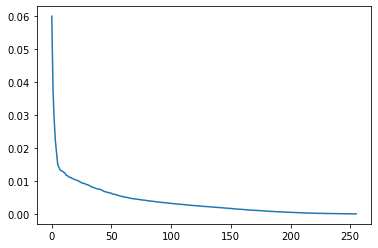

In [8]:
pca = PCA()
pca.fit(embeddings)

plt.plot(pca.explained_variance_ratio_)
plt.show()

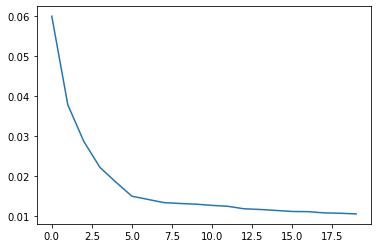

In [9]:
plt.plot(pca.explained_variance_ratio_[:20])
plt.show()

In [10]:
latent_directions = pca.components_[:6]
latent_directions = torch.from_numpy(np.array(latent_directions)).to(device).type(torch.float32)
print(latent_directions.shape)

torch.Size([6, 256])


In [11]:
def extract_encodings(model, src_seq, mel_target, mel_aug, p_norm, e_input, src_len, mel_len, d_target=None, p_target=None, e_target=None, max_src_len=None, max_mel_len=None, speaker_embed=None, d_control=1.0, p_control=1.0, e_control=1.0):
    with torch.no_grad():
        src_mask = utils.get_mask_from_lengths(src_len, max_src_len)
        mel_mask = utils.get_mask_from_lengths(mel_len, max_mel_len)
        (text_encoding, pitch_embedding, speaker_encoding, energy_embedding), noise_encoding, d_prediction, p_prediction, e_prediction, mel_len, mel_mask, (aug_posterior_d, aug_posterior_p, aug_posterior_e) = model.module.style_modeling(
                        src_seq, speaker_embed, mel_target, mel_aug, p_norm, e_input, src_len, mel_len, src_mask, mel_mask, d_target, p_target, e_target, max_mel_len, d_control, p_control, e_control, seperate=True)
        return (text_encoding, pitch_embedding, speaker_encoding, energy_embedding), noise_encoding, d_prediction, p_prediction, e_prediction, mel_len, mel_mask, (aug_posterior_d, aug_posterior_p, aug_posterior_e)

src_len = torch.from_numpy(np.array([text.shape[1]])).long().to(device)
(text_encoding, pitch_embedding, speaker_encoding, energy_embedding), noise_encoding, d_prediction, p_prediction, e_prediction, mel_len, mel_mask, (aug_posterior_d, aug_posterior_p, aug_posterior_e) = extract_encodings(model, text, mel, mel, f0_norm, energy, src_len, mel_len,speaker_embed=speaker_embed)
style_modeling_output = text_encoding + pitch_embedding + speaker_encoding + energy_embedding


In [12]:
alpha = 10

print('Style 0 - Monster/Human\nStyle 1 - Calm/Angry\n ???????')

for i, direction in enumerate(latent_directions):
    print(f"Direction +-{i}")
    style = style_modeling_output + alpha * direction

    mel_output, mel_output_postnet = model.module.decode(style, mel_mask)
    mel_postnet_torch = mel_output_postnet.transpose(1, 2).detach()
    mel_output_postnet = mel_output_postnet[0].cpu().transpose(0, 1).detach()

    output = utils.vocoder_infer(mel_postnet_torch, vocoder, '', write=False)
    IPython.display.display(IPython.display.Audio(output, rate=22050))


    style = style_modeling_output - alpha * direction

    mel_output, mel_output_postnet = model.module.decode(style, mel_mask)
    mel_postnet_torch = mel_output_postnet.transpose(1, 2).detach()
    mel_output_postnet = mel_output_postnet[0].cpu().transpose(0, 1).detach()

    output = utils.vocoder_infer(mel_postnet_torch, vocoder, '', write=False)
    IPython.display.display(IPython.display.Audio(output, rate=22050))

Style 0 - Monster/Human
Style 1 - Calm/Angry
 ???????
Direction +-0


Direction +-1


Direction +-2


Direction +-3


Direction +-4


Direction +-5


In [13]:
# VCTK Model
# Define model
model = nn.DataParallel(STYLER()).to(device)

checkpoint_path = os.path.join(hp.checkpoint_path())
checkpoint = torch.load(os.path.join(
    checkpoint_path, 'checkpoint_300000.pth.tar'))
model.load_state_dict(checkpoint['model'])

model.requires_grad = False
model.eval()

DataParallel(
  (module): STYLER(
    (style_modeling): StyleModeling(
      (style_encoder): StyleEncoder(
        (text_encoder): Encoder(
          (src_word_emb): Embedding(152, 256, padding_idx=0)
          (layer_stack): ModuleList(
            (0): FFTBlock(
              (slf_attn): MultiHeadAttention(
                (w_qs): Linear(in_features=256, out_features=256, bias=True)
                (w_ks): Linear(in_features=256, out_features=256, bias=True)
                (w_vs): Linear(in_features=256, out_features=256, bias=True)
                (attention): ScaledDotProductAttention(
                  (softmax): Softmax(dim=2)
                )
                (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
                (fc): Linear(in_features=256, out_features=256, bias=True)
                (dropout): Dropout(p=0.2, inplace=False)
              )
              (pos_ffn): PositionwiseFeedForward(
                (w_1): Conv1d(256, 1024, kernel_size=(9,)

In [14]:
with torch.no_grad():
    output1 = synthesize('', model, vocoder, text, target_sentence, speaker_embed, speaker_id, False, mel, mel_len, f0, f0_norm, energy, write=False)
    output2 = synthesize('', model, vocoder, text, target_sentence, target_speaker_embed, speaker_id, False, mel, mel_len, f0, f0_norm, energy, write=False)

print("Sentence:" + target_sentence)

print("Original Reference:")
IPython.display.display(IPython.display.Audio(audio_path))

print("Original Recreation:")
IPython.display.display(IPython.display.Audio(output1, rate=22050))

print("Target Speaker:")
IPython.display.display(IPython.display.Audio(speaker_example))
                        
print("Synth Result:")
IPython.display.display(IPython.display.Audio(output2, rate=22050))

Sentence:show me the man who has everything, and i'll show you my next victim.
Original Reference:


Original Recreation:


Target Speaker:


Synth Result:


In [15]:
connection = sqlite3.connect('embeddings_vctk.db')
embeddings = pd.read_sql_query("SELECT * from embeddings", connection)
embeddings.drop('num', inplace=True, axis=1)

embeddings.head()

col0     col1     col2     col3     col4     col5     col6     col7  \
0  0.04138  0.89296 -0.58898  0.15250 -0.15050  0.90370 -1.04802  0.51776   
1 -1.23688  0.55067 -0.72775  1.42438 -0.49620  0.64842 -1.11152  0.55505   
2 -0.96563  1.24220  0.86769 -0.83441  0.07714  3.45867  1.57194  1.73948   
3 -1.23364  1.30044 -0.65190 -1.21820  0.52659 -0.05760  0.59851 -1.80482   
4 -1.12878  0.66625  0.13506  0.43954  0.46133  1.08567 -0.80610 -0.18130   

      col8     col9  ...   col246   col247   col248   col249   col250  \
0 -0.23149 -1.66341  ...  0.77146 -1.46576 -0.96970 -0.44065 -0.42187   
1  0.54297 -3.47475  ...  0.03622  0.54394  0.31680 -1.85637 -0.78802   
2 -0.63217 -2.49766  ... -0.85937  0.77154  0.65036 -0.74558 -1.50692   
3 -0.12953  0.99145  ...  3.04594  3.06240 -1.51283  1.71135 -0.88583   
4  0.63021 -0.50499  ...  0.12582 -0.27402 -0.41516 -0.60780 -1.54761   

    col251   col252   col253   col254   col255  
0 -0.97504 -2.24116 -0.93121  0.09054 -1.56059  
1  0.88636 -1.73302 -0.27191  1.33928 -2.38784  
2 -0.30866 -0.59975  0.77905  0.96356 -2.33750  
3 -1.17013 -0.03186 -0.09544 -0.12746  1.06343  
4 -1.07574 -2.21144 -0.04028  1.54420 -1.12876  

[5 rows x 256 columns]

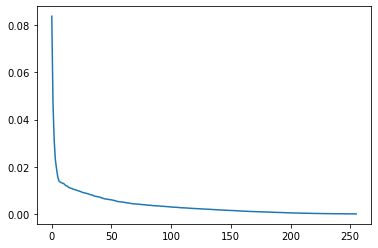

In [16]:
pca = PCA()
pca.fit(embeddings)

plt.plot(pca.explained_variance_ratio_)
plt.show()

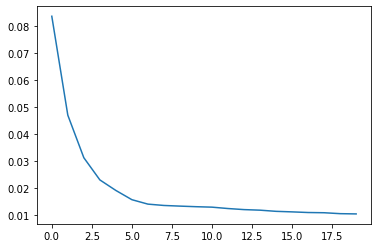

In [17]:
plt.plot(pca.explained_variance_ratio_[:20])
plt.show()

In [18]:
latent_directions = pca.components_[:6]
latent_directions = torch.from_numpy(np.array(latent_directions)).to(device).type(torch.float32)
print(latent_directions.shape)

torch.Size([6, 256])


In [19]:
def extract_encodings(model, src_seq, mel_target, mel_aug, p_norm, e_input, src_len, mel_len, d_target=None, p_target=None, e_target=None, max_src_len=None, max_mel_len=None, speaker_embed=None, d_control=1.0, p_control=1.0, e_control=1.0):
    with torch.no_grad():
        src_mask = utils.get_mask_from_lengths(src_len, max_src_len)
        mel_mask = utils.get_mask_from_lengths(mel_len, max_mel_len)
        (text_encoding, pitch_embedding, speaker_encoding, energy_embedding), noise_encoding, d_prediction, p_prediction, e_prediction, mel_len, mel_mask, (aug_posterior_d, aug_posterior_p, aug_posterior_e) = model.module.style_modeling(
                        src_seq, speaker_embed, mel_target, mel_aug, p_norm, e_input, src_len, mel_len, src_mask, mel_mask, d_target, p_target, e_target, max_mel_len, d_control, p_control, e_control, seperate=True)
        return (text_encoding, pitch_embedding, speaker_encoding, energy_embedding), noise_encoding, d_prediction, p_prediction, e_prediction, mel_len, mel_mask, (aug_posterior_d, aug_posterior_p, aug_posterior_e)

src_len = torch.from_numpy(np.array([text.shape[1]])).long().to(device)
(text_encoding, pitch_embedding, speaker_encoding, energy_embedding), noise_encoding, d_prediction, p_prediction, e_prediction, mel_len, mel_mask, (aug_posterior_d, aug_posterior_p, aug_posterior_e) = extract_encodings(model, text, mel, mel, f0_norm, energy, src_len, mel_len,speaker_embed=speaker_embed)
style_modeling_output = text_encoding + pitch_embedding + speaker_encoding + energy_embedding

In [20]:
alpha = 10

for i, direction in enumerate(latent_directions):
    print(f"Direction +-{i}")
    style = style_modeling_output + alpha * direction

    mel_output, mel_output_postnet = model.module.decode(style, mel_mask)
    mel_postnet_torch = mel_output_postnet.transpose(1, 2).detach()
    mel_output_postnet = mel_output_postnet[0].cpu().transpose(0, 1).detach()

    output = utils.vocoder_infer(mel_postnet_torch, vocoder, '', write=False)
    IPython.display.display(IPython.display.Audio(output, rate=22050))


    style = style_modeling_output - alpha * direction

    mel_output, mel_output_postnet = model.module.decode(style, mel_mask)
    mel_postnet_torch = mel_output_postnet.transpose(1, 2).detach()
    mel_output_postnet = mel_output_postnet[0].cpu().transpose(0, 1).detach()

    output = utils.vocoder_infer(mel_postnet_torch, vocoder, '', write=False)
    IPython.display.display(IPython.display.Audio(output, rate=22050))

Direction +-0


Direction +-1


Direction +-2


Direction +-3


Direction +-4


Direction +-5
